Jako poslední pokus vyřešit logickou hru Futoshiki jsem zkusil použít genetické algoritmy. Ty by měly umožňovat řešit optimalizační úlohy, takže třeba zaberou i v tomto případě.

Pokud vás zajímá pouze výsledek mého snažení, tak musím dopředu avizovat, že jsem se k nějakým dobrým výsledkům nedopracoval. Jednotlivá řešení konvergovala, ale obtížně jsem se dostával k řešení, které by bylo úplně bez chyb.

Pro vás ostatní, uvádím postup pro jedno zadání hry s velikostí 5x5.

Nechtěl jsem psát vše úplně od počátku, proto jsem vyzkoušel použít existující knihovnu [PyGAD](https://pygad.readthedocs.io/en/latest/). A bylo to také ze studijních důvodů. Ono se vždy lépe zkouší nový software na nějakém reálném problému, než jen opakovat příklady z tutoriálu.

# Zdroj testovacích dat

Testovací data mám již připravená ve třídě `SampleSource`, takže stačí je jen použít stejně jako v předchozím příspěvku.

In [1]:
from Futoshiki_DataSource import SampleSource

samples = SampleSource()

sample_number = 5
print(*samples.data(sample_number), sep='\n')

SIZE = samples.size(sample_number)
grid = samples.grid(sample_number)
constraints = samples.constraints(sample_number)

0>0 5 0 0

0 2 0 0 0
        ^
0 0 0 0 0

0 0 0 3 0

0 0 0 2<0


# Řešení s využitím PyGAD

## Reprezentace řešení
První otázka je, jak budu reprezentovat jedno řešení (chromozom). Pro použití v PyGAD je nejvhodnější, pokud je řešení reprezentováno jako jednorozměrné pole celočíselných hodnot. To mně docela vyhovuje, takže budu jedno řešení reprezentovat jako spojení jednotlivých řádků řešení hry za sebou. Každé políčko (gen) může nabývat hodnot 1..N.

In [2]:
import math
import random
import pygad
import numpy as np

## Výpočet kvality řešení
Jedním z klíčových bodů GA je stanovení "kvality" jednoho řešení.

V mém případě je lepší to řešení, které má méně konfliktů v požadovaných omezeních. Těmi omezeními se rozumí unikátnost v řádku a slouci, a také splnění explicitně požadovaných relací v zadání.

Následující metoda `fitness` tedy počítá, kolik konfliktů má zadané řešení.

* Nejdříve si převedu vektor zpět do matice (to aby se mně lépe pracovalo s řádky, sloupci a jednotlivými políčky).
* Pro každý řádek zjistím rozdíl mezi velikosti řádku a velikostí množiny hodnot v řádku. Pokud mám v řádku opakovaně stejné číslo, pak je výsledek nenulový.
* Stejně tak pro každý sloupec zjistím rozdíl velikosti sloupce a velikostí množiny hodnot ve sloupci.
* Nakonec projdu všechna požadovaná omezení a ověřuji, jestli jsou platná. Pokud ne, opět přispívají do výsledné hodnoty kvality.
* Výsledek je pak součet všech zjištěných konfliků, převedený do záporné hodnoty (to proto, aby mělo horší řešení menší hodnotu fitness).

In [3]:
def fitness(solution, index):
    res = 0
    size = math.isqrt(len(solution))
    grid = np.reshape(solution, (size, size))
    res += sum((size - len(set(row)) for row in grid))
    res += sum((size - len(set(col)) for col in grid.T))
    for low, high in constraints:
        res += int(not (grid[low] < grid[high]))
    return - res

## Rozsahy hodnot pro jednotlivé geny
Dříve jsem v reprezentaci řešení napsal, že každý gen může nabývat hodnot z rozmezí 1..N. Ono to ale není tak úplně pravda.

V případě, že mám v zadání specifikovánu hodnotu konkrétního políčka (genu), pak chci, aby gen nabýval pouze této hodnoty.

Navíc mohu při posouzení povolených hodnot pro jednotlivé geny vzít v úvahu také explcitně stanovená omezení a omezení unikátnosti v řádku a sloupci.

Například, pokud mám pro nějaké políčko stanovenu hodnotu v zadání, pak pro všechna ostatní políčka v řádku a sloupci platí, že tuto hodnotu obsahovat nesmí.

Nebo pokud je explicitně stanovena relace mezi dvěma políčky, pak množina povolených hodnot pro větší políčko nesmí obsahovat minimum hodnot menšího políčka (pokud by taková hodnota byla povolena, pak by nebylo možné omezení splnit).

A navíc, mezi relacemi je tranzitivní vztah, kdy změnou rozsahu hodnot pro jeden gen mohou být ovlivněny rozsahy hodnot jiných genů.

Takhle tedy vypadá implementace metody `gene_spaces`, která mně počítá množiny povolených hodnot pro jednotlivé geny:

In [4]:
def gene_spaces(grid, constraints):
    size = len(grid)
    spaces = [[{val} if val else set(range(1, size + 1)) for val in row] for row in grid]

    def flatten_size(item):
        return len(item) if isinstance(item, set) else sum((flatten_size(s) for s in item))

    curr_size = flatten_size(spaces)
    while True:
        # unique value constraint for rows and columns
        for x in range(size):
            for y in range(size):
                sp = spaces[x][y]
                if len(sp) == 1:
                    for i in range(size):
                        if i != x:
                            spaces[i][y] -= sp
                        if i != y:
                            spaces[x][i] -= sp

        # constraints defined by assignment
        for low, high in constraints:
            l0, l1, h0, h1 = *low, *high

            min_value = min(spaces[l0][l1])
            spaces[h0][h1] = {v for v in spaces[h0][h1] if v > min_value}

            max_value = max(spaces[h0][h1])
            spaces[l0][l1] = {v for v in spaces[l0][l1] if v < max_value}

        new_size = flatten_size(spaces)
        if new_size >= curr_size:
            break
        curr_size = new_size

    return spaces


def gene_space_prep(space):
    return [list(space[i][j]) for i in range(len(space)) for j in range(len(space))]
        
gene_spaces(grid, constraints)

[[{2, 3, 4}, {1, 3}, {5}, {1, 4}, {1, 2, 3, 4}],
 [{1, 3, 4, 5}, {2}, {1, 3, 4}, {1, 4, 5}, {1, 3, 4}],
 [{1, 2, 3, 4, 5}, {1, 3, 4, 5}, {1, 2, 3, 4}, {1, 4, 5}, {2, 3, 4, 5}],
 [{1, 2, 4, 5}, {1, 4, 5}, {1, 2, 4}, {3}, {1, 2, 4, 5}],
 [{1, 3, 4, 5}, {1, 3, 4, 5}, {1, 3, 4}, {2}, {3, 4, 5}]]

Postup je zhruba tento:
* pro každý hledaný gen definuji množinu povolených hodnot v rozsahu 1..N, geny se zadanou hodnotou mají množinu jednoprvkovou.
* dále opakuji cyklus, dokud se mně nějak mění množiny hodnot pro všechny geny
* v každém cyklu pak:
    * pokud je množina povolených hodnot políčka jednoprvková, odečtu tuto hodnotu od všech ostatních množin v řádku a ve sloupci
    * procházím všechna omezení a z množiny povolených hodnot většího políčka odečtu minimum povolených hodnot políčka menšího
    * obdobně tak z množiny povolených hodnot menšího políčka odečtu maximum políčka většího

Výsledek si můžete ověřit výše.

## Spuštění řešení
A teď již se můžu dostat k vlastnímu spuštění řešení.

Nejdříve potřebuji instanci třídy `GA`, ve které stanovuji parametry chování algoritmu.
V tomto konkrétním případě jsem nastavoval tyto parametry (možnosti nastavení algoritmu jsou daleko širší, pro zájemce odkazuji na [dokumentaci PyGAD](https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class)):


`num_generations` - maximální počet generací

`num_parents_mating` - celový počet řešení z jedné generace, které budou vybrány jako rodiče pro generaci následující

`fitness_func` - funkce pro výpočet kvality jednoho řešení

`sol_per_pop` - počet řešení v populaci

`num_genes` - počet genů, které tvoří jedno řešení 

`gene_type` - typ hodnot, kterých nabývají geny

`gene_space` - rozsahy povolených hodnot pro jednotlivé geny

`parent_selection_type` - algoritmus výběru rodičů pro následující generaci

`crossover_type` - způsob křížení rodičů a vytvoření jejich potomků

`mutation_type` - metoda výběru genů pro mutaci

`mutation_probability` - pravděpodobnost mutace jednoho genu

`stop_criteria` - kritérium, při jehož splnění se algoritmus zastaví (najdu řešení s kvalitou rovnou 0)

Dále již postačuje spustit řešení zavoláním metody `run`.


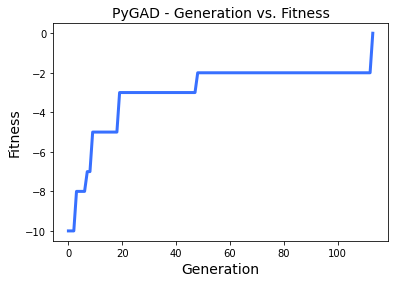

SUCCESS: (113)
[[3 1 5 4 2]
 [4 2 1 5 3]
 [5 3 2 1 4]
 [2 5 4 3 1]
 [1 4 3 2 5]]


In [5]:
random.seed(0)
np.random.seed(0)

ga = pygad.GA(num_generations=10000,
              num_parents_mating=16,
              fitness_func=fitness,
              sol_per_pop=20,
              num_genes=SIZE**2,
              gene_type=int,
              gene_space=gene_space_prep(gene_spaces(grid, constraints)),
              parent_selection_type='sss',
              crossover_type='single_point',
              mutation_type='random',
              mutation_probability=0.01,
              stop_criteria='reach_0',
              )
ga.run()

ga.plot_fitness()

result = np.where(ga.last_generation_fitness == 0)
if len(result[0]) > 0:
    s = samples.size(sample_number)
    print(f"SUCCESS: ({ga.generations_completed})\n{ga.population[result[0][0]].reshape((s, s))}")
else:
    print("BEST FITNESS:", ga.last_generation_fitness.max())

Připojený graf zachycuje vývoj hodnoty fitness pro nejlepší řešení v každé generaci.
K vyhovujícímu řešení jsem dospěl po 113 generacích. 

# Poznámky na závěr
Jak jsem již upozorňoval na začátku článku, toto je ukázka řešení, které se povedlo. Pokud jsem ale obdobný postup zkoušel na zadání složitější, výsledky nebyly zdaleka tak příznivé.

Co jsem postupně ještě zkoušel:
1. Hledat různá nastavení parametrů pro velikost populace, počet rodičů, algoritmus výběru rodičů, algoritmus výběru genů pro mutaci a pravděpodobnost mutace tak, abych dostal vyhovující řešení. Někdy se to povedlo, ale nenašel jsem jednu univerzální sadu parametrů, která by vyhovovala pro všechna řešení.
2. Zkusil jsem jinou reprezentaci jednoho řešení:
    * každé řešení bylo reprezentováno jako seznam řádků
    * v řádcích byla zachována všechna požadovaná omezení a unikátnost hodnot
    * křížení rodičů jsem prováděl na úrovni řádků
    * mutace jsem naopak dělal pouze v rámci jednoho řádku přehozením hodnot tak, aby zůstala zachována všechna omezení v rámci řádku
3. Použil jsem inkrementální přístup algoritmu, kdy se nevytvářela celá generace ale křížili se jen dva vybraní rodiče

Každý z pokusů byl v něčem lepší, a někdy zase horší. Nenašel jsem jeden úplně vyhovující. Proto jsem vás těmi pokusy neobtěžoval
a prezentoval jsem jen ten nejjednodušší postup.

A to je dnes vše.